Importance sampling OPE

Loading Data
Behavior policy (σ=0.8): 4885 timesteps
Target policy (σ=0.4):   4896 timesteps

Number of timesteps: 4885
Mean weight:         1.3566
Std weight:          1.1845
Max weight:          3.9997
Min weight:          0.0000

Evaluation Results
Predicted cumulative reward: 19614.7
True cumulative reward:      17936.5
Absolute error:              1678.2
Percent error:               9.4%

Saved figure: importance_sampling_rf.png


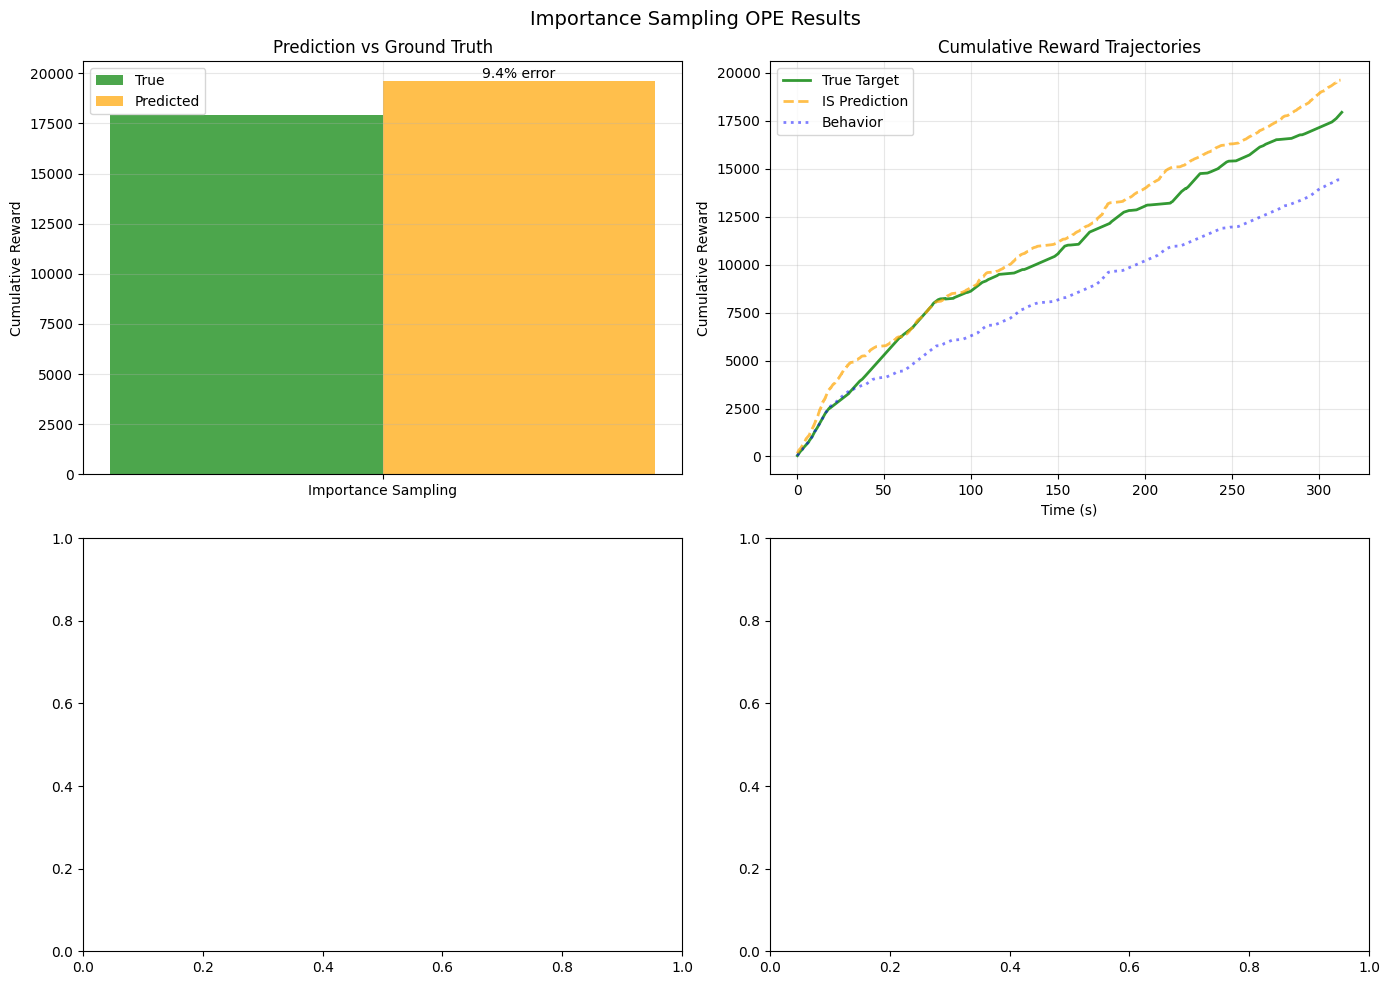

In [7]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt


class ImportanceSamplingOPE:
    def __init__(self):
        self.action_features = ['v_cmd', 'omega_cmd']

    def load_data(self, csv_path):
        df = pd.read_csv(csv_path)
        return df

    def compute_importance_weights(self, df_behavior, df_target, max_weight=5.0):
        behavior_sigma = float(df_behavior['sigma_policy'].iloc[0])
        target_sigma = float(df_target['sigma_policy'].iloc[0])

        weights = []

        for idx in range(len(df_behavior)):
            v_nominal = df_behavior['v_smooth'].iloc[idx]
            omega_nominal = df_behavior['omega_smooth'].iloc[idx]
            v_actual = df_behavior['v_cmd'].iloc[idx]
            omega_actual = df_behavior['omega_cmd'].iloc[idx]

  #behavior policy probability
            p_behavior_v = norm.pdf(v_actual, v_nominal, behavior_sigma * 0.1)
            p_behavior_omega = norm.pdf(omega_actual, omega_nominal,
                                        behavior_sigma * 0.15)
            p_behavior = p_behavior_v * p_behavior_omega

    #target policy probability
            p_target_v = norm.pdf(v_actual, v_nominal, target_sigma * 0.1)
            p_target_omega = norm.pdf(omega_actual, omega_nominal,
                                     target_sigma * 0.15)
            p_target = p_target_v * p_target_omega


            if p_behavior > 1e-10:
                weight = min(p_target / p_behavior, max_weight)
            else:
                weight = max_weight

            weights.append(weight)

        return np.array(weights)

    def evaluate(self, df_behavior, df_target, max_weight=5.0):
        weights = self.compute_importance_weights(
            df_behavior, df_target, max_weight
        )

        print(f"Number of timesteps: {len(weights)}")
        print(f"Mean weight:         {np.mean(weights):.4f}")
        print(f"Std weight:          {np.std(weights):.4f}")
        print(f"Max weight:          {np.max(weights):.4f}")
        print(f"Min weight:          {np.min(weights):.4f}")
        print()

    #Applying weights to rewards
        behavior_rewards = df_behavior['reward'].values[:len(weights)]
        weighted_rewards = weights * behavior_rewards

        predicted = np.sum(weighted_rewards)
        true_value = df_target['cumulative_reward'].iloc[-1]

        error_abs = abs(predicted - true_value)
        error_pct = 100 * error_abs / abs(true_value)
        print("Evaluation Results")
        print(f"Predicted cumulative reward: {predicted:.1f}")
        print(f"True cumulative reward:      {true_value:.1f}")
        print(f"Absolute error:              {error_abs:.1f}")
        print(f"Percent error:               {error_pct:.1f}%")
        print()

        return {
            'predicted': predicted,
            'true': true_value,
            'error_abs': error_abs,
            'error_pct': error_pct,
            'weights': weights,
            'weighted_rewards': weighted_rewards
        }


def visualize_results(df_behavior, df_target, is_results):
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    ax = axes[0, 0]
    predicted = is_results['predicted']
    true_val = is_results['true']
    error_pct = is_results['error_pct']

    x = [0]
    width = 0.4

    ax.bar(x[0] - width/2, true_val, width, label='True',
           alpha=0.7, color='green')
    ax.bar(x[0] + width/2, predicted, width, label='Predicted',  alpha=0.7, color='orange')

    ax.text(x[0] + width/2, predicted, f'{error_pct:.1f}% error',ha='center', va='bottom', fontsize=10)

    ax.set_xticks([0])
    ax.set_xticklabels(['Importance Sampling'])
    ax.set_ylabel('Cumulative Reward')
    ax.set_title('Prediction vs Ground Truth')
    ax.legend()
    ax.grid(alpha=0.3)
    ax = axes[0, 1]
    is_weighted_cumulative = np.cumsum(is_results['weighted_rewards'])
    time_is = df_behavior['time'].iloc[:len(is_weighted_cumulative)]

    ax.plot(df_target['time'], df_target['cumulative_reward'],label='True Target', linewidth=2, alpha=0.8, color='green')
    ax.plot(time_is, is_weighted_cumulative,label='IS Prediction', linewidth=2, linestyle='--',alpha=0.7, color='orange')
    ax.plot(df_behavior['time'], df_behavior['cumulative_reward'],label='Behavior', linewidth=2, linestyle=':',alpha=0.5, color='blue')

    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Cumulative Reward')
    ax.set_title('Cumulative Reward Trajectories')
    ax.legend()
    ax.grid(alpha=0.3)

    ax = axes[1, 0]
    weights = is_results['weights']

    # ax.hist(weights, bins=50, alpha=0.7, edgecolor='black', color='orange')
    # ax.axvline(np.mean(weights), color='red', linestyle='--',linewidth=2, label=f'Mean: {np.mean(weights):.3f}')
    # ax.axvline(np.median(weights), color='blue', linestyle=':',linewidth=2, label=f'Median: {np.median(weights):.3f}')
    # ax.set_xlabel('Importance Weight')
    # ax.set_ylabel('Frequency')
    # ax.set_title('Importance Weight Distribution')
    # ax.legend()
    # ax.grid(alpha=0.3)

    # ax = axes[1, 1]
    # time_weights = df_behavior['time'].iloc[:len(weights)]

    # ax.plot(time_weights, weights, alpha=0.5, linewidth=1)
    # ax.axhline(np.mean(weights), color='red', linestyle='--',linewidth=2, label=f'Mean: {np.mean(weights):.3f}')
    # ax.set_xlabel('Time (s)')
    # ax.set_ylabel('Importance Weight')
    # ax.set_title('Importance Weights Over Time')
    # ax.legend()
    # ax.grid(alpha=0.3)

    plt.suptitle('Importance Sampling OPE Results', fontsize=14)
    plt.tight_layout()
    return fig


if __name__ == "__main__":
    print("Importance sampling OPE")
    print()

    is_evaluator = ImportanceSamplingOPE()
    print("Loading Data")
    df_behavior = is_evaluator.load_data('ekf_slam_logging_sigma0.8.csv')
    df_target = is_evaluator.load_data('ekf_slam_evaluation_sigma0.4.csv')

    print(f"Behavior policy (σ=0.8): {len(df_behavior)} timesteps")
    print(f"Target policy (σ=0.4):   {len(df_target)} timesteps")
    print()

    is_results = is_evaluator.evaluate(df_behavior, df_target)
    fig = visualize_results(df_behavior, df_target, is_results)
    plt.savefig('importance_sampling_rf.png', dpi=300, bbox_inches='tight')
    print("Saved figure: importance_sampling_rf.png")

**Percent error: 9.4%**